<a href="https://colab.research.google.com/github/sgagankumar/GhostCar-Training/blob/master/GhostCar_Behavioural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UDACITY SIMULATOR BEHAVIOURAL CLONING TECHNIQUE

In [ ]:
!git clone https://github.com/sgagankumar/GhostCar-TrainingData

fatal: destination path 'GhostCar-TrainingData' already exists and is not an empty directory.


In [ ]:
!ls GhostCar-TrainingData

driving_log_all.csv   driving_log_right.csv  README.md
driving_log_left.csv  IMG


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
random.seed(0)
import os

Using TensorFlow backend.


In [ ]:
datadir = 'GhostCar-TrainingData'
columns = ['image','steering']
data = pd.read_csv(os.path.join(datadir, 'driving_log_right.csv'), names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,image,steering
0,IMG/file501.jpg,0
1,IMG/file502.jpg,0
2,IMG/file503.jpg,0
3,IMG/file504.jpg,0
4,IMG/file505.jpg,0


In [ ]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['image']=data['image'].apply(path_leaf)
data.head()

,image,steering
0,file501.jpg,0
1,file502.jpg,0
2,file503.jpg,0
3,file504.jpg,0
4,file505.jpg,0


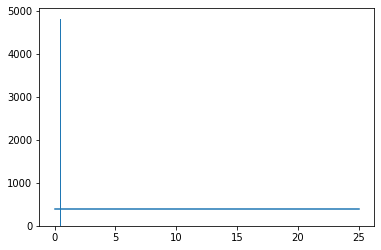

In [ ]:
num_bins=25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) *0.5
# print(center)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total Data   :  8732


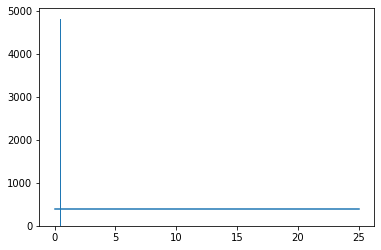

In [ ]:
# remove_list = []
# for j in range(num_bins):
#     list_ = []
#     for i in range(len(data['steering'])):
#         if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
#             list_.append(i)
#     list_ = shuffle(list_)
#     list_ = list_[samples_per_bin:]
#     remove_list.extend(list_)

print('Total Data   : ', len(data))
# print('Removed Data : ', len(remove_list))
# data.drop(data.index[remove_list], inplace=True)
# print('remaining:',len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center= indexed_data[0]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[1]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples : {}\nValid Samples    : {}'.format(len(X_train), len(X_valid)))

Training Samples : 6985
Valid Samples    : 1747


Text(0.5, 1.0, 'Validation set')

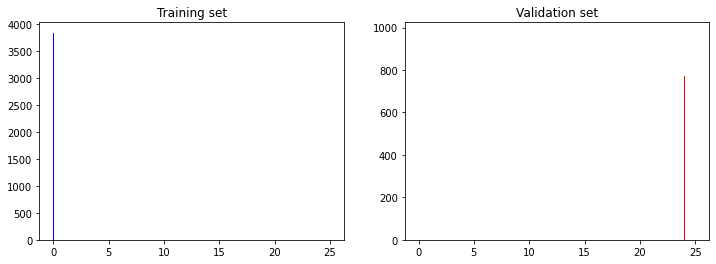

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

In [ ]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x":(-0.1,0.1), "y":(-0.1,0.1)})
    image = pan.augment_image(image)
    return image

In [ ]:
def img_rand_brightness(image):
    bright = iaa.Multiply((0.2, 1.2))
    image = bright.augment_image(image)
    return image

In [ ]:
def img_rand_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Modified Image - Angle:-0.0')

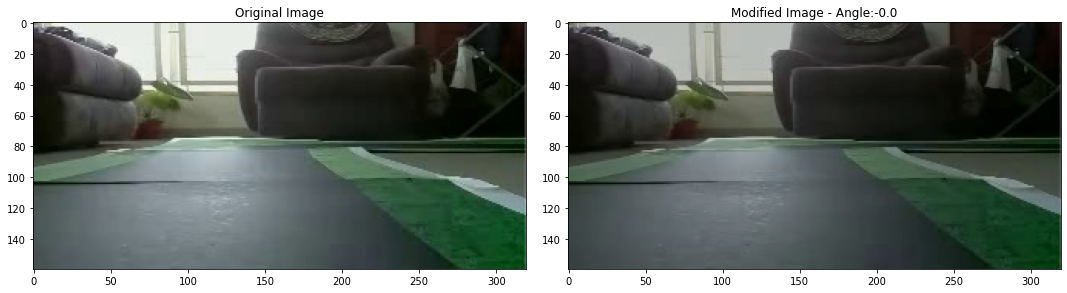

In [ ]:
rand_index=random.randint(0, 500)
image = image_paths[rand_index]
steering = steerings[rand_index]

original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
panned_image = pan(original_image)
bright_image = img_rand_brightness(original_image)
flip_image, steering = img_rand_flip(original_image, steering)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(bright_image)             # Values : zoomed_image, panned_image, bright_image, flip_image
axs[1].set_title('Modified Image - Angle:'+str(steering))

In [ ]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_rand_brightness(image)
    if np.random.rand() < 0.5:
        pass
        # image, steering_angle = img_rand_flip(image, steering_angle)
    return image, steering_angle

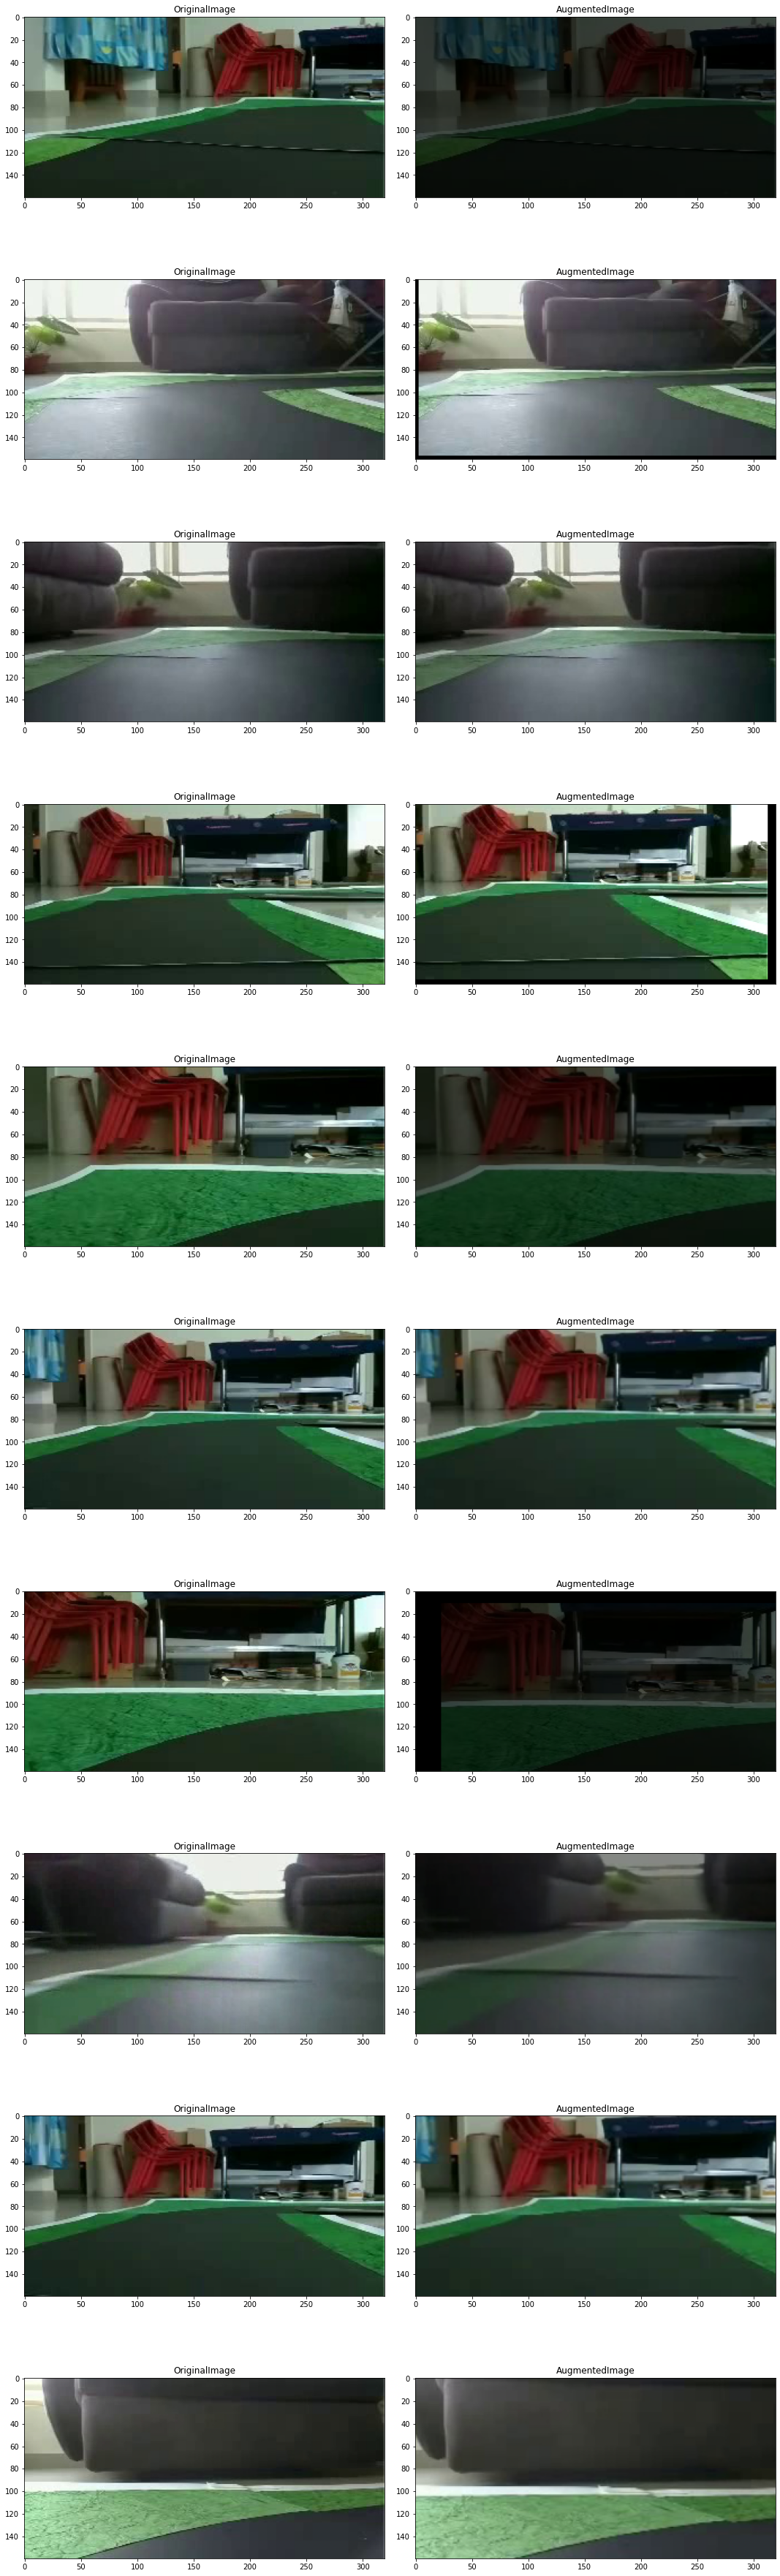

In [ ]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
for i in range(10):
    randnum = random.randint(0, len(image_paths)-1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title('OriginalImage')
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('AugmentedImage')

In [ ]:
def img_preprocess(img):
    # img = mpimg.imread(img)
    img = img[80:159, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
# preprocessed_image = img_preprocess(image)

# fig, axs = plt.subplots(1, 2, figsize=(15, 10))
# fig.tight_layout()
# axs[0].imshow(original_image)
# axs[0].set_title('Original Image')
# axs[1].imshow(preprocessed_image)
# axs[1].set_title('Preprocessing Image')

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img=[]
        batch_steering=[]

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im=img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

In [ ]:
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_valid = np.array(list(map(img_preprocess, X_valid)))

In [ ]:
# plt.imshow(X_train[random.randint(0, len(X_train)-1)])
# print(X_train.shape)

In [ ]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    # model.add(Dropout(0.5))
    model.add(Flatten())

    model.add(Dense(100, activation='elu'))
    # model.add(Dropout(0.5))

    model.add(Dense(50, activation='elu'))
    # model.add(Dropout(0.5))

    model.add(Dense(10, activation='elu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1))

    optimizerAdam = Adam(lr = 0.001)
    model.compile(loss='mse', optimizer=optimizerAdam)
    return model

In [ ]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  import sys


In [ ]:
# history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), steps_per_epoch=300, epochs=11, validation_data = batch_generator(X_valid, y_valid, 100, 0), validation_steps=200, verbose=1, shuffle=1)

Epoch 1/11
300/300 [==============================] - 224s 747ms/step - loss: 42.8650 - val_loss: 5.5634
Epoch 2/11
300/300 [==============================] - 215s 717ms/step - loss: 11.3341 - val_loss: 2.8350
Epoch 3/11
300/300 [==============================] - 216s 720ms/step - loss: 8.3534 - val_loss: 3.2918
Epoch 4/11
300/300 [==============================] - 217s 723ms/step - loss: 7.9151 - val_loss: 6.0903
Epoch 5/11
300/300 [==============================] - 216s 719ms/step - loss: 7.8866 - val_loss: 0.8268
Epoch 6/11
300/300 [==============================] - 215s 717ms/step - loss: 6.9108 - val_loss: 6.2670
Epoch 7/11
300/300 [==============================] - 214s 715ms/step - loss: 6.1733 - val_loss: 0.5415
Epoch 8/11
300/300 [==============================] - 214s 714ms/step - loss: 5.9699 - val_loss: 0.3258
Epoch 9/11
300/300 [==============================] - 215s 716ms/step - loss: 5.6604 - val_loss: 1.2331
Epoch 10/11
300/300 [==============================] - 216s 71

Text(0.5, 0, 'Epoch')

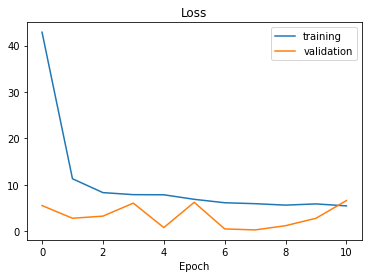

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>